In [1]:
] activate .

  Activating project at `~/research/11_2024_winter/multiagent-coverage-v2`


In [2]:
] st

Status `~/research/11_2024_winter/multiagent-coverage-v2/Project.toml`
  [944b1d66] CodecZlib v0.7.6
  [a198fc80] CoverageControllers v1.0.0-DEV `https://github.com/dev10110/CoverageControllers.jl.git#main`
  [a93c6f00] DataFrames v1.6.1
  [31c24e10] Distributions v0.25.111
  [7a1cc6ca] FFTW v1.8.0
  [5789e2e9] FileIO v1.16.3
  [08572546] FlameGraphs v1.0.0
  [f6369f11] ForwardDiff v0.10.36
  [a98d9a8b] Interpolations v0.15.1
  [033835bb] JLD2 v0.4.53
  [2fda8390] LsqFit v0.15.0
  [30363a11] NetCDF v0.12.0
  [91a5bcdd] Plots v1.40.8
  [132c30aa] ProfileSVG v0.2.2
  [92933f4c] ProgressMeter v1.10.2
  [3cdcf5f2] RecipesBase v1.3.4
  [73b3b457] SpatiotemporalGPs v1.0.1-DEV `https://github.com/dev10110/SpatiotemporalGPs.jl#main`
  [90137ffa] StaticArrays v1.9.7
  [2913bbd2] StatsBase v0.34.3
  [f3b207a7] StatsPlots v0.15.7
  [ade2ca70] Dates
  [37e2e46d] LinearAlgebra
  [de0858da] Printf


In [3]:
using ProgressMeter

In [25]:
using Revise

using Plots

using LinearAlgebra

using LsqFit, Random

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


# First, we load the data

In [26]:
include("src/env_data.jl")

Main.EnvData

In [27]:
fn = EnvData.get_filename(1,1) # for month 1, day 1

windData = EnvData.load_data(fn, counts=[128, 64, -1]) # load only parts of the data

Main.EnvData.WindData{Vector{Float64}, Array{Float64, 3}, Interpolations.Extrapolation{Float64, 3, Interpolations.GriddedInterpolation{Float64, 3, Array{Float64, 3}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}([458.04998779296875, 458.1499938964844, 458.25, 458.3500061035156, 458.45001220703125, 458.54998779296875, 458.6499938964844, 458.75, 458.8500061035156, 458.95001220703125  …  469.8500061035156, 469.95001220703125, 470.04998779296875, 470.1499938964844, 470.25, 470.3500061035156, 470.45001220703125, 470.54998779296875, 470.6499938964844, 470.75], [5269.75, 5269.85009765625, 5269.9501953125, 5270.0498046875, 5270.14990234375, 5270.25, 5270.35009765625, 5270.4501953125, 5270.5498046875, 5270.64990234375  …  5275.14990234375, 5275.25, 5275.35009765625, 527

In [28]:
size(windData.WX)

(128, 64, 48)

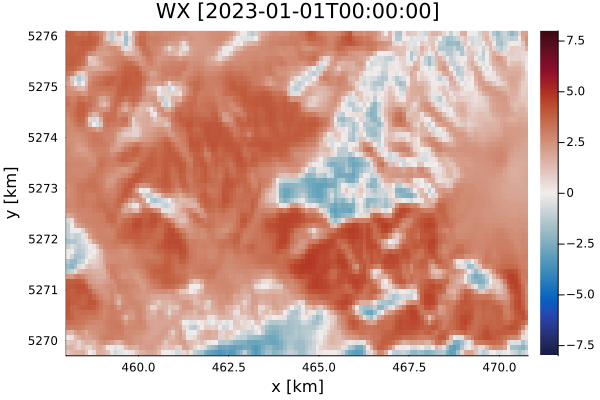

In [29]:
heatmap(windData, 1; plottype=:wx)

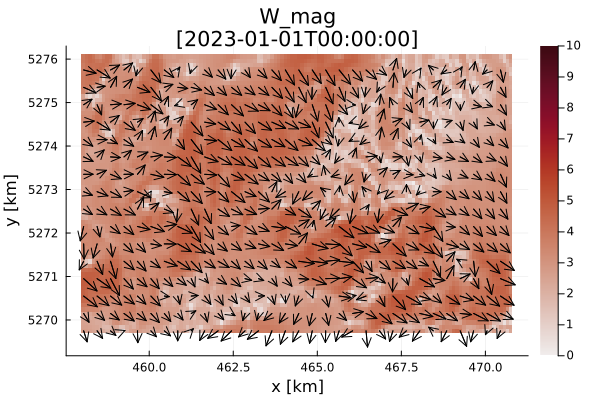

In [30]:
quiver_ax_xs = windData.X[1:4:end]
quiver_ax_ys = windData.Y[1:4:end]

quiver_xs = zeros(length(quiver_ax_xs), length(quiver_ax_ys))
quiver_ys = zeros(length(quiver_ax_xs), length(quiver_ax_ys))
for i=1:length(quiver_ax_xs)
    for j=1:length(quiver_ax_ys)
        quiver_xs[i, j] = quiver_ax_xs[i]
        quiver_ys[i, j] = quiver_ax_ys[j]
    end
end

quiver_wx = windData.WX[1:4:end, 1:4:end, 1]
quiver_wy = windData.WY[1:4:end, 1:4:end, 1]

gr()
heatmap(windData, 1; plottype=:mag, clims=(0, 10))
quiver!(vec(quiver_xs), vec(quiver_ys), quiver=(0.1*vec(quiver_wx), 0.1*vec(quiver_wy)), color=:black)

In [31]:
# savefig("wind_mag_dir.svg")

In [32]:
function urand(m, M)
    return (M - m) * rand() + m
end

urand (generic function with 1 method)

## Determine some variogram

In [33]:
include("src/variograms.jl")

Main.Variograms

In [34]:
# the goal is to estimate the spatial and temporal variograms

In [35]:
function vectorize(windData::EnvData.WindData)
    
    ax_xs = 1:30 # length(windData.X)
    ax_ys = 1:30 # length(windData.Y)
    ax_ts = 1:30 # length(windData.T)

    numel = prod([length(ax_xs), length(ax_ys), length(ax_ts)])

    # construct the vectorized data
    ts = zeros(numel)
    xs = zeros(numel)
    ys = zeros(numel)
    wxs = zeros(numel)
    wys = zeros(numel)

    counter = 1
    for i=1:length(ax_xs)
        for j=1:length(ax_ys)
            for k=1:length(ax_ts)
                wx = windData.WX[i, j, k]
                wy = windData.WY[i, j, k]
                xs[counter] = windData.X[i]
                ys[counter] = windData.Y[j]
                ts[counter] = windData.T[k]
                wxs[counter] = wx
                wys[counter] = wy
                counter += 1
            end
        end
    end

    return xs, ys, ts, wxs, wys
end




function randvectorize(windData::EnvData.WindData; N=3000)

    ts = zeros(N)
    xs = zeros(N)
    ys = zeros(N)
    wxs = zeros(N)
    wys = zeros(N)

    minx, maxx = extrema(windData.X)
    miny, maxy = extrema(windData.Y)
    mint, maxt = extrema(windData.T)

    
    @showprogress for i=1:N
        t = urand(mint, maxt)
        x = urand(minx, maxx)
        y = urand(miny, maxy)

        ts[i] = t
        xs[i] = x
        ys[i] = y
        wxs[i], wys[i] = windData(x, y, t)
    end

    return xs, ys, ts, wxs, wys
end
        

randvectorize (generic function with 2 methods)

In [36]:
function empirical_variogram(windData, trange, prange)

    # vectorize data
    xs, ys, ts, wxs, wys = randvectorize(windData, N=10000)
    ps = hcat(xs, ys)

    # compute the variogram
    vars_x, counts_x = Variograms.empirical_variogram_spatiotemporal(ts, ps, wxs, trange, prange)

    return vars_x, counts_x
end

empirical_variogram (generic function with 1 method)

In [94]:
trange = range(0, 3*60, length=30)
prange = range(0, 5.0, length=30)

# define a seed
Random.seed!(3);
vars_x, counts_x = empirical_variogram(windData, trange, prange)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


([0.22703616489683637 0.9664609817565963 … 3.6360188975828285 3.6729834369974097; 0.33863785374396116 0.8431181649357496 … 3.683878394026299 3.5535073699594277; … ; 2.2878626269062434 2.656451737075712 … 4.578098760389504 4.598376781493317; 2.2288817033087516 2.732456641858898 … 4.608432515471814 4.6927630089478125], [481.0 1484.0 … 10247.0 10040.0; 520.0 1424.0 … 10425.0 10256.0; … ; 472.0 1263.0 … 8941.0 8868.0; 453.0 1291.0 … 9076.0 8882.0])

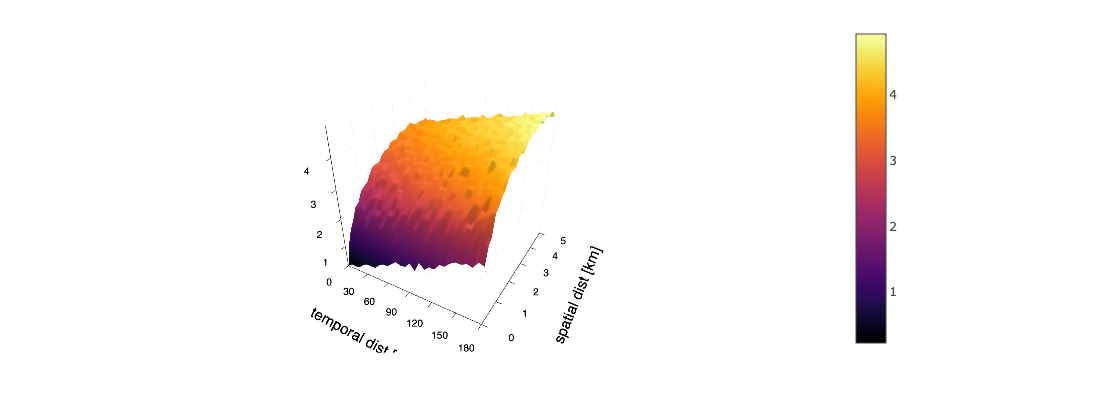

In [95]:
surface(trange, prange, vars_x')
xlabel!("temporal dist [min]")
ylabel!("spatial dist [km]")

In [96]:
function kernel_M12_M12(dt, ds, params)
    σsq, λt, λs = params
    return σsq * exp(-λt * dt) * exp(-λs * ds)
end

function variogram_M12_M12(dt, ds, params)
    k0 = kernel_M12_M12(0, 0, params)
    kx = kernel_M12_M12(dt, ds, params)
    return k0 - kx
end

function fitting_variogram_M12_M12(dtds, params)
    
    os = zeros(size(dtds, 1))
    for i=1:length(os)
        os[i] = variogram_M12_M12(dtds[i, 1], dtds[i, 2], params)
    end

    return os
end
function vectorize(trange::VF, prange::VF, data::MF) where {F, VF <: AbstractVector{F}, MF <: AbstractMatrix{F}}

    numel = length(trange) * length(prange)
    
    vec_t = zeros(numel)
    vec_p = zeros(numel)
    vec_d = zeros(numel)

    counter = 1
    for i=1:length(trange)
        for j=1:length(prange)
            vec_t[counter] = trange[i]
            vec_p[counter] = prange[j]
            vec_d[counter] =data[i, j]
            counter += 1
        end
    end

    return vec_t, vec_p, vec_d
end

vectorize (generic function with 3 methods)

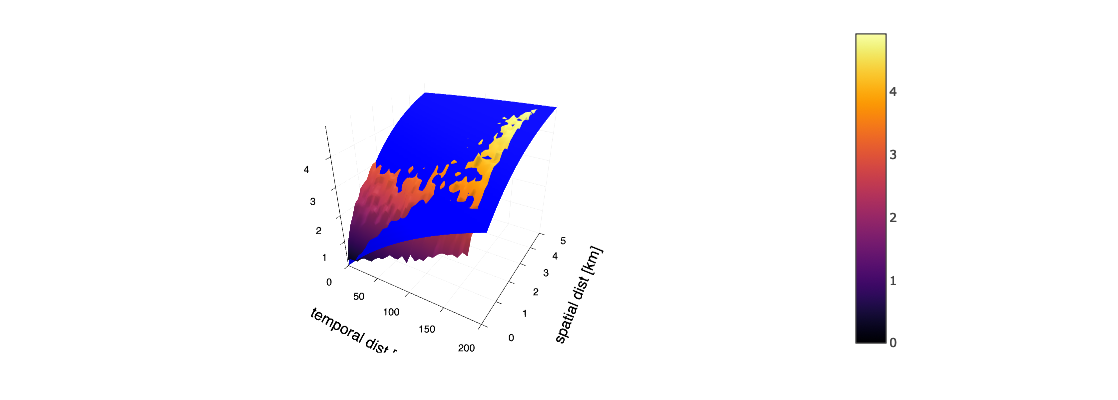

In [97]:

# first guess
σsq = 5.0
lt = 200.0 # minutes
ls = 2.0 # km
params_guess = [σsq, 1/lt, 1/ls]

surface(0:200., 0:0.1:5., (dt, ds) -> variogram_M12_M12( dt, ds, params_guess) , color=:blue)
surface!(trange, prange, vars_x')
xlabel!("temporal dist [min]")
ylabel!("spatial dist [km]")



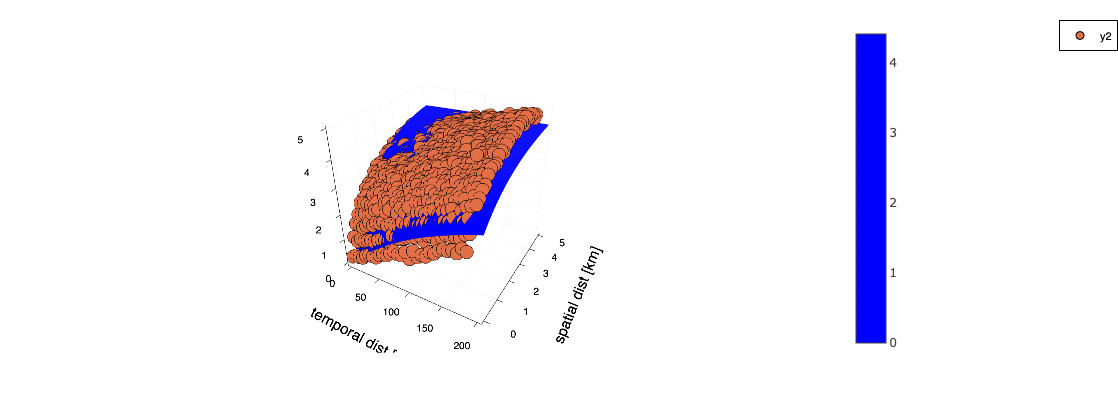

In [98]:
vec_t, vec_p, vec_vars_x = vectorize(trange, prange, vars_x)

lsqfit = LsqFit.curve_fit(fitting_variogram_M12_M12, hcat(vec_t, vec_p), vec_vars_x, params_guess)

@assert lsqfit.converged

surface(0:200., 0:0.1:5., (dt, ds) -> variogram_M12_M12( dt, ds, lsqfit.param) , color=:blue)
scatter!(vec_t, vec_p, vec_vars_x)
xlabel!("temporal dist [min]")
ylabel!("spatial dist [km]")



In [99]:
# therefore, the fitted kernel constants are 
σs = sqrt(lsqfit.param[1])
σt = 1.0
@show σt
@show σs
lt = 1/lsqfit.param[2]
ls = 1/lsqfit.param[3]
@show lt # minutes
@show ls # km


σt = 1.0
σs = 2.1145935079804907
lt = 182.86957760522463
ls = 1.609459650299633


1.609459650299633

In [100]:
# use hardcoded values
σt = 1.0
σs = 2.114593506953788
lt = 182.869577978737
ls = 1.609459640726444

1.609459640726444

In [101]:
params = [(σt * σs)^2, 1/lt, 1/ls]

3-element Vector{Float64}:
 4.47150569965112
 0.005468378125290332
 0.6213265463113079

In [102]:
gr()


Plots.GRBackend()

In [103]:
plotly()

Plots.PlotlyBackend()

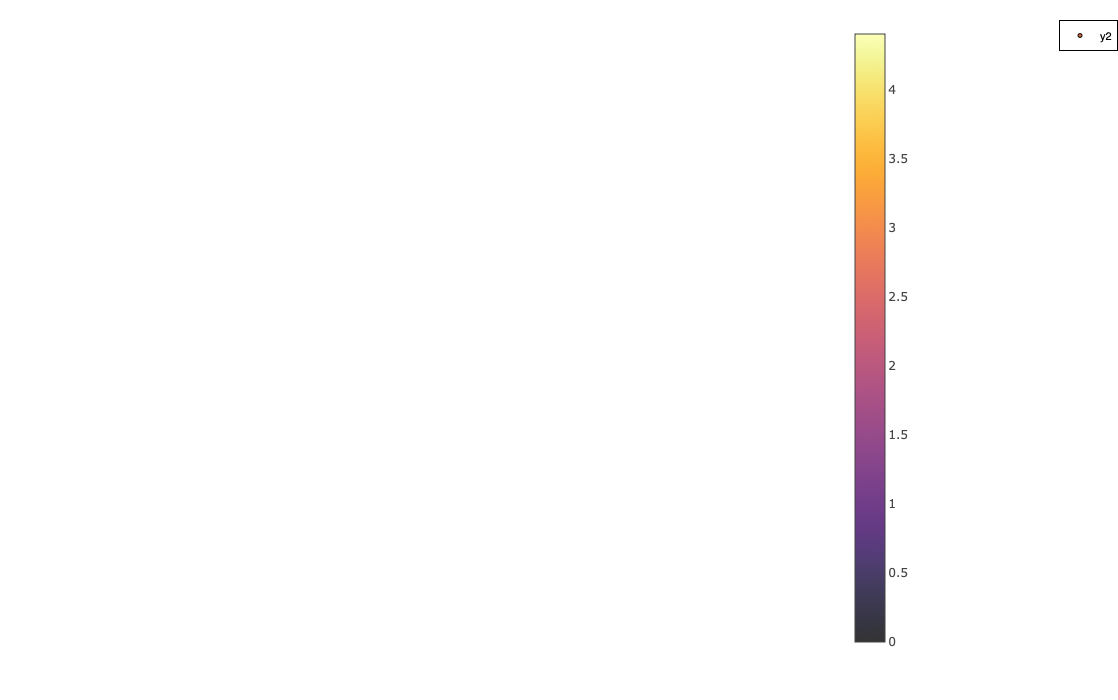

In [104]:
surface(0:200., 0:0.1:5., (dt, ds) -> variogram_M12_M12( dt, ds, params), alpha = 0.8)
scatter!(vec_t, vec_p, vec_vars_x, markersize=2)
xlabel!("temporal dist [min]")
ylabel!("spatial dist [km]")
plot!(size=(700, 700))

In [105]:
# savefig("results/variogram.pdf")